In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution

In [2]:
events = {}

evt_500_0p25_0p004_false = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayFalse_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-0p25_ctau-0p004_v3.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_1p2_0p019_false = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayFalse_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-1p2_ctau-0p019_v3.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_5p0_0p08_false = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayFalse_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_v3.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_0p25_0p004_true = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayTrue_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-0p25_ctau-0p004_v3.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_1p2_0p019_true = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayTrue_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-1p2_ctau-0p019_v3.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_5p0_0p08_true = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Cutdecay/CutDecayTrue_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_v3.root",
    schemaclass=NanoAODSchema,
).events()

In [3]:
events['evt_500_0p25_0p004_false'] = evt_500_0p25_0p004_false
events['evt_500_1p2_0p019_false'] = evt_500_1p2_0p019_false
events['evt_500_5p0_0p08_false'] = evt_500_5p0_0p08_false
events['evt_500_0p25_0p004_true'] = evt_500_0p25_0p004_true
events['evt_500_1p2_0p019_true'] = evt_500_1p2_0p019_true
events['evt_500_5p0_0p08_true'] = evt_500_5p0_0p08_true

In [4]:
events

{'evt_500_0p25_0p004_false': <NanoEventsArray [<event 1:1:1>, ... <event 1:2:383>] type='26351 * event'>,
 'evt_500_1p2_0p019_false': <NanoEventsArray [<event 1:1:1>, ... <event 1:1:92>] type='18795 * event'>,
 'evt_500_5p0_0p08_false': <NanoEventsArray [<event 1:1:1>, ... <event 1:3:500>] type='18701 * event'>,
 'evt_500_0p25_0p004_true': <NanoEventsArray [<event 1:1:10>, ... <event 1:3:485>] type='4511 * event'>,
 'evt_500_1p2_0p019_true': <NanoEventsArray [<event 1:1:1>, ... <event 1:1:98>] type='29893 * event'>,
 'evt_500_5p0_0p08_true': <NanoEventsArray [<event 1:1:1>, ... <event 1:3:486>] type='27031 * event'>}

In [5]:
events['evt_500_0p25_0p004_false'].GenPart.fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'vx',
 'vy',
 'vz',
 'px',
 'py',
 'pz',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [6]:
def extract_values(events, sample):
    
    genpart = events["{0}".format(sample)].GenPart
    dps = genpart[abs(genpart.pdgId) == 32]
    mask = ak.all(abs(dps.children.pdgId) == 13, axis=-1)
    dps_tomu = dps[mask]
    
    dps_tomu_vec = vector.zip({
        "pt": dps_tomu.pt,
        "eta": dps_tomu.eta,
        "phi": dps_tomu.phi,
        "mass": dps_tomu.mass})
    
    lxyz = ak.flatten(((dps_tomu.children.vx - dps_tomu.vx)**2 + (dps_tomu.children.vy - dps_tomu.vy)**2 + (dps_tomu.children.vz - dps_tomu.vz)**2)**0.5) 
    gamma = ak.flatten(dps_tomu_vec.gamma)
    beta = ak.flatten(dps_tomu_vec.beta)
    
    print("DP mass : {0}".format(dps_tomu.mass))
    
    return lxyz, gamma, beta

In [7]:
def plotting(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    lxyz, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = lxyz/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(ak.flatten(lxyz_gb), range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18, loc='upper right')
    ax[i][j].set_xlabel(r"$V_{xyz}$/$\beta\gamma$")

In [9]:
pip install zfit

  Obtaining dependency information for zfit from https://files.pythonhosted.org/packages/1e/f5/6b561d4d53b421e65a32220dfe6f61cdf74903280b56de00cba644d85c71/zfit-0.23.0-py2.py3-none-any.whl.metadata
  Using cached zfit-0.23.0-py2.py3-none-any.whl.metadata (44 kB)
  Obtaining dependency information for colored from https://files.pythonhosted.org/packages/75/d1/548f697f88872321525e294f8863efbdd1c313964b7f94e49ab0dc4f2895/colored-2.2.4-py3-none-any.whl.metadata
  Using cached colored-2.2.4-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/e3/51/9b208e85196941db2f0654ad0357ca6388ab3ed67efdbfc799f35d1f83aa/colorlog-6.9.0-py3-none-any.whl.metadata
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for deprecated from https://files.pythonhosted.org/packages/1d/8f/c7f227eb42cfeaddce3eb0c96c60cbca37797fa7b34f8e1aeadf6c5c0983/Deprecated-1.2.15-py2.py3-none-any.whl.metadata

In [10]:
import zfit

/opt/conda/lib/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2024-11-15 17:44:07.155166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 17:44:07.171809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 17:44:07.171824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
def zfit_plotting(events, sample, ranges, i,j, co):
    
    plt_range = (0, ranges)
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = ak.to_numpy(ak.flatten(rho/(gamma * beta)))
    obs_space = zfit.Space("lxyz_gb", limits=plt_range)
    data = zfit.Data.from_numpy(obs=obs_space, array=lxyz_gb)
    
    lambda_param = zfit.Parameter("lambda", 1)
    exp_model = zfit.pdf.Exponential(lambda_param, obs=obs_space)

    nll = zfit.loss.UnbinnedNLL(model=exp_model, data=data)

    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    param_val = result.params[lambda_param]['value']
    
    offset = 0
    scale_param = 1 / param_val

    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)

    x_vals = np.linspace(*plt_range, 100)
    pdf_vals = exp_model.pdf(x_vals, norm_range=obs_space)
    ax[i][j].plot(x_vals, pdf_vals, label=fr"exp[ -(x - {offset:.3e}) / {scale_param:.3e} ] / {scale_param:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18, loc='upper right')
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

DP mass : [[0.267, 0.258], [0.236, 0.248], [0.251, ... 0.25], [0.251, 0.252], [0.249, 0.256]]
DP mass : [[1.33, 1.2], [1.24, 1.17], [1.2, 1.19], ... [1.2, 1.19], [1.2, 1.2], [1.2, 1.21]]
DP mass : [[4.98, 5.02], [5.02, 4.95], [4.98, 5], [5, 5, ... 4.91], [5, 5], [5, 5], [5, 4.98]]
DP mass : [[0.282, 0.252], [0.261, 0.254], [0.261, ... 0.251], [0.247, 0.256], [0.247, 0.254]]
DP mass : [[1.2, 1.2], [1.2, 1.18], [1.19, 1.19], ... [1.19, 1.21], [1.21, 1.11], [1.21, 1.21]]
DP mass : [[5, 5], [5, 5], [5, 5], [5.02, 5], ... [5.02, 5.03], [5, 5], [5, 5], [5.02, 4.95]]


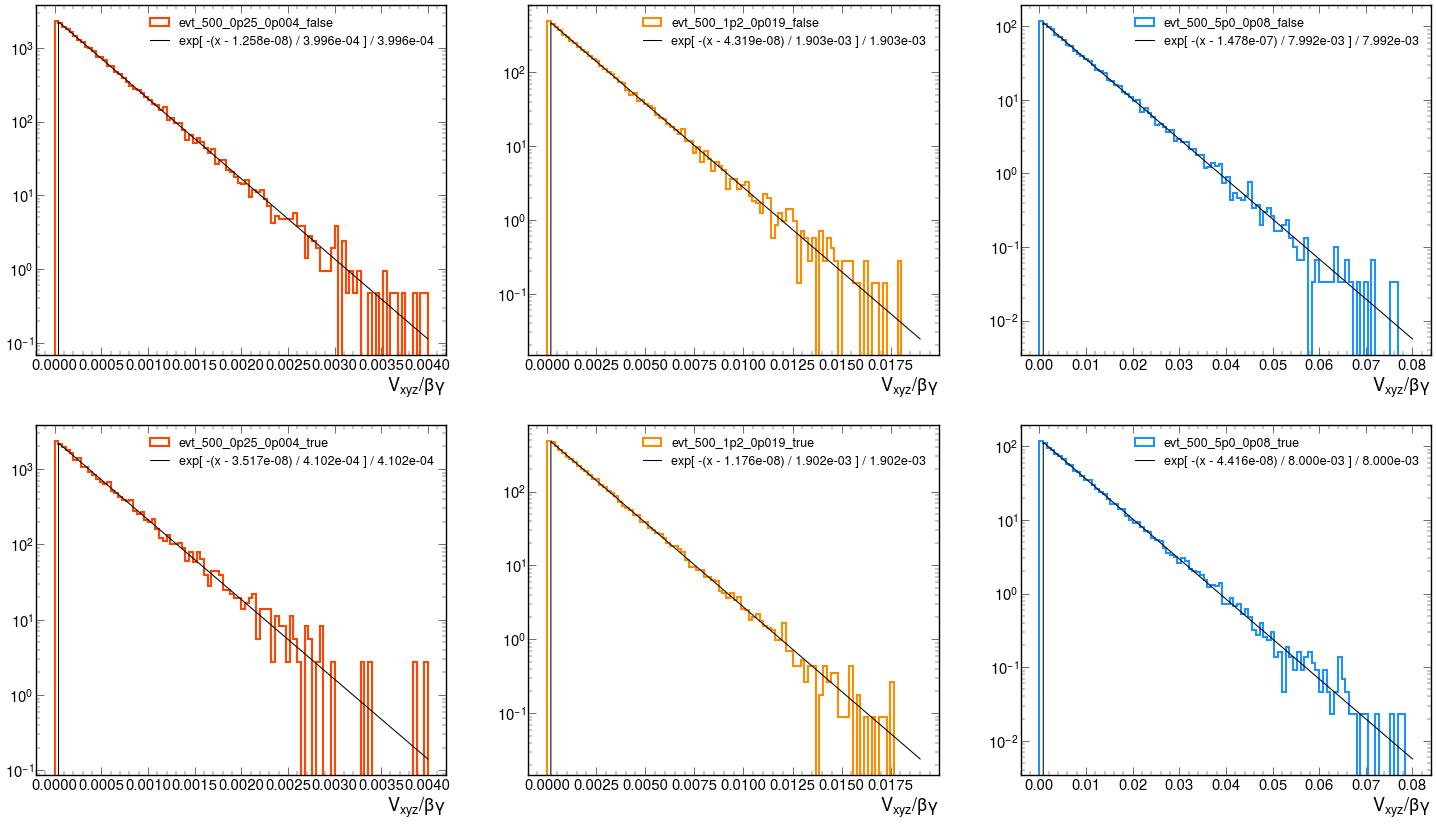

In [8]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events, "evt_500_0p25_0p004_false", 0.004,0,0, "orangered")
plotting(events, "evt_500_1p2_0p019_false", 0.019,0,1, "darkorange")
plotting(events, "evt_500_5p0_0p08_false", 0.08,0,2, "dodgerblue")

plotting(events, "evt_500_0p25_0p004_true", 0.004,1,0, "orangered")
plotting(events, "evt_500_1p2_0p019_true", 0.019,1,1, "darkorange")
plotting(events, "evt_500_5p0_0p08_true", 0.08,1,2, "dodgerblue")

In [18]:
def plotting_lxy(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    
    lxyz, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = lxyz
    P = stats.expon.fit(lxyz_gb)
    
    ax[i].hist(ak.flatten(lxyz_gb), range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)
    ax[i].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$V_{xyz}$")

DP mass : [[0.267, 0.258], [0.236, 0.248], [0.251, ... 0.25], [0.251, 0.252], [0.249, 0.256]]
DP mass : [[1.33, 1.2], [1.24, 1.17], [1.2, 1.19], ... [1.2, 1.19], [1.2, 1.2], [1.2, 1.21]]
DP mass : [[4.98, 5.02], [5.02, 4.95], [4.98, 5], [5, 5, ... 4.91], [5, 5], [5, 5], [5, 4.98]]
DP mass : [[0.282, 0.252], [0.261, 0.254], [0.261, ... 0.251], [0.247, 0.256], [0.247, 0.254]]
DP mass : [[1.2, 1.2], [1.2, 1.18], [1.19, 1.19], ... [1.19, 1.21], [1.21, 1.11], [1.21, 1.21]]
DP mass : [[5, 5], [5, 5], [5, 5], [5.02, 5], ... [5.02, 5.03], [5, 5], [5, 5], [5.02, 4.95]]


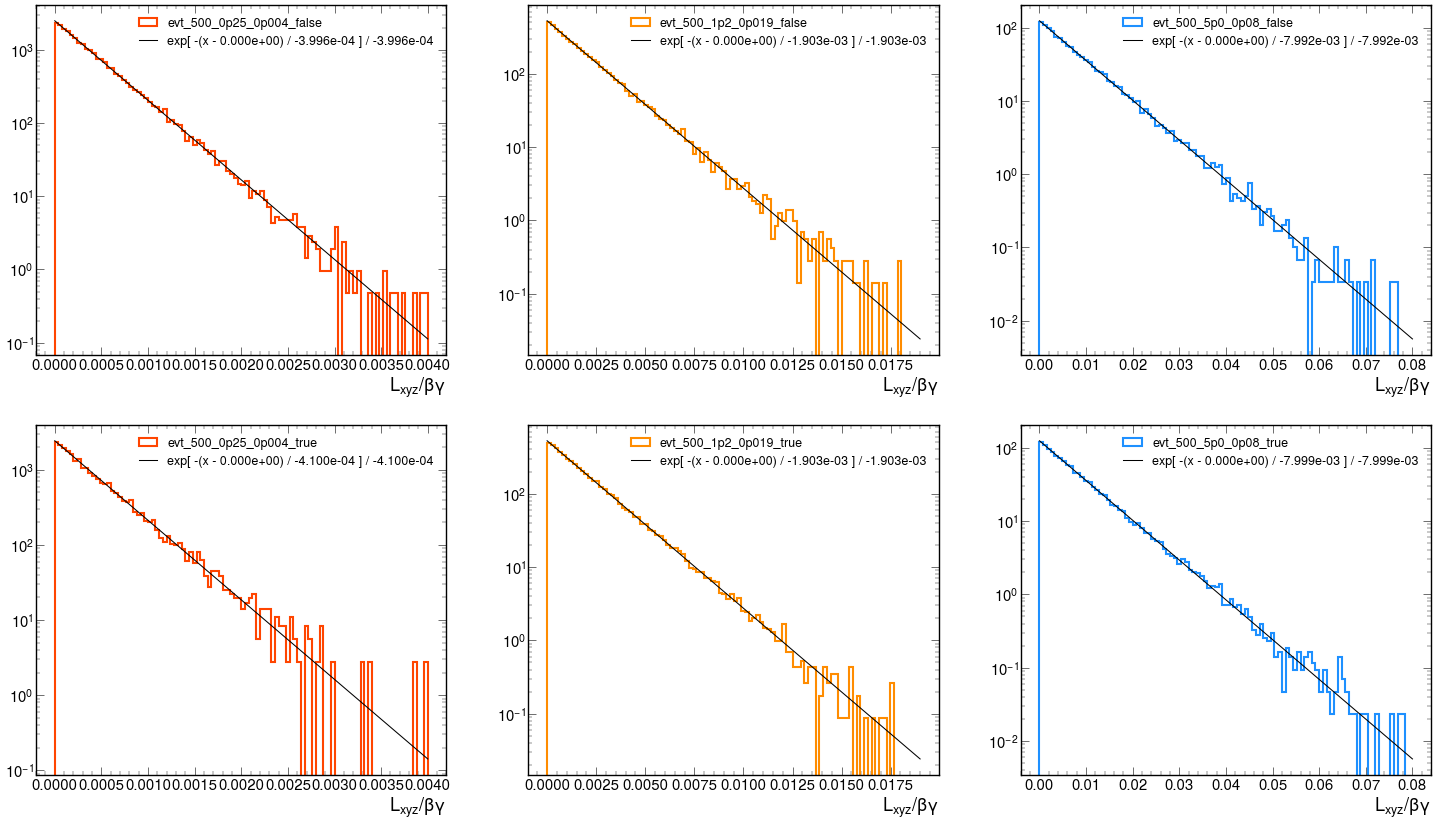

In [12]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

zfit_plotting(events, "evt_500_0p25_0p004_false", 0.004,0,0, "orangered")
zfit_plotting(events, "evt_500_1p2_0p019_false", 0.019,0,1, "darkorange")
zfit_plotting(events, "evt_500_5p0_0p08_false", 0.08,0,2, "dodgerblue")

zfit_plotting(events, "evt_500_0p25_0p004_true", 0.004,1,0, "orangered")
zfit_plotting(events, "evt_500_1p2_0p019_true", 0.019,1,1, "darkorange")
zfit_plotting(events, "evt_500_5p0_0p08_true", 0.08,1,2, "dodgerblue")

In [22]:
def zfit_plotting_lxy(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = ak.to_numpy(ak.flatten(rho))
    obs_space = zfit.Space("lxyz_gb", limits=plt_range)
    data = zfit.Data.from_numpy(obs=obs_space, array=lxyz_gb)
    
    lambda_param = zfit.Parameter("lambda", 1)
    exp_model = zfit.pdf.Exponential(lambda_param, obs=obs_space)

    nll = zfit.loss.UnbinnedNLL(model=exp_model, data=data)

    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    param_val = result.params[lambda_param]['value']
    
    offset = 0
    scale_param = 1 / param_val

    ax[i].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)

    x_vals = np.linspace(*plt_range, 100)
    pdf_vals = exp_model.pdf(x_vals, norm_range=obs_space)
    ax[i].plot(x_vals, pdf_vals, label=fr"exp[ -(x - {offset:.3e}) / {scale_param:.3e} ] / {scale_param:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$L_{xyz}$")